# Tutorial 4: Backward propagation.
In this tutorial, we will explore the backward propagation features of `PyPO`. We demonstrate this by making a source, consisting of two randomly placed uniformly lit rectangles, propagating this field to a plane above the source and backwards to another plane at the same height of the source. We can then investigate to what degree `PyPO` can recover the shape of the source.

In [6]:
#%matplotlib notebook # Uncomment for interactive plots when running the notebook!

import numpy as np

from PyPO.System import System
from PyPO.Enums import FieldComponents, Projections, Objects

s = System()

2025-08-28 15:03:30 - WARNING - System override set to True. 


2025-08-28 15:03:32 - INFO - Added plane source_1 to system. 
2025-08-28 15:03:32 - INFO - Added plane source_2 to system. 
2025-08-28 15:03:32 - INFO - Added plane plane_up to system. 
2025-08-28 15:03:32 - INFO - Added plane plane_down to system. 
2025-08-28 15:03:32 - INFO - Rotated element source_1 by ('0.000e+00', '0.000e+00', '3.000e+01') degrees around ('0.000e+00', '0.000e+00', '0.000e+00'). 
2025-08-28 15:03:32 - INFO - Rotated element source_2 by ('0.000e+00', '0.000e+00', '1.100e+02') degrees around ('0.000e+00', '0.000e+00', '0.000e+00'). 
2025-08-28 15:03:32 - INFO - Translated element plane_up by ('0.000e+00', '0.000e+00', '1.000e+02') millimeters. 
2025-08-28 15:03:32 - INFO - Translated element source_1 by ('5.000e+00', '5.000e+00', '0.000e+00') millimeters. 
2025-08-28 15:03:32 - INFO - Translated element source_2 by ('-5.000e+00', '-5.000e+00', '0.000e+00') millimeters. 


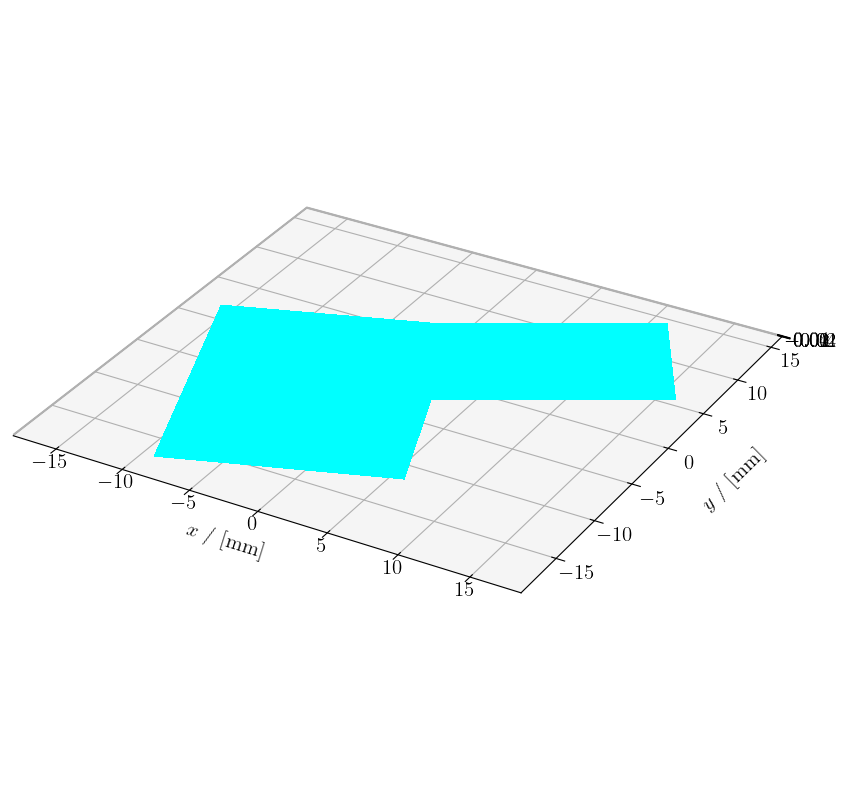

In [7]:
source_1 = {
        "name"      : "source_1",
        "gmode"     : "xy",
        "lims_x"    : np.array([-10, 10]),
        "lims_y"    : np.array([-5, 5]),
        "gridsize"  : np.array([301, 301])
        }
source_2 = {
        "name"      : "source_2",
        "gmode"     : "xy",
        "lims_x"    : np.array([-10, 10]),
        "lims_y"    : np.array([-8, 8]),
        "gridsize"  : np.array([301, 301])
        }

plane_up = {
        "name"      : "plane_up",
        "gmode"     : "xy",
        "lims_x"    : np.array([-50, 50]),
        "lims_y"    : np.array([-50, 50]),
        "gridsize"  : np.array([501, 501]),
        "flip"      : True
        }

plane_down = {
        "name"      : "plane_down",
        "gmode"     : "xy",
        "lims_x"    : np.array([-20, 20]),
        "lims_y"    : np.array([-20, 20]),
        "gridsize"  : np.array([301, 301])
        }

s.addPlane(source_1)
s.addPlane(source_2)

s.addPlane(plane_up)
s.addPlane(plane_down)

s.rotateGrids("source_1", np.array([0, 0, 30]))
s.rotateGrids("source_2", np.array([0, 0, 110]))

UDict_1 = {
        "name"      : "U1_source",
        "lam"       : 1,
        "E0"        : 1,
        "phase"     : 0,
        "pol"       : np.array([1,0,0])
        }

UDict_2 = {
        "name"      : "U2_source",
        "lam"       : 1,
        "E0"        : 1,
        "phase"     : 0, # In phase with source 1
        #"phase"     : -np.pi, # Out of phase
        "pol"       : np.array([1,0,0])
        }

s.createUniformSource(UDict_1, "source_1")
s.createUniformSource(UDict_2, "source_2")

s.translateGrids("plane_up", np.array([0, 0, 100]))
s.translateGrids("source_1", np.array([5, 5, 0]))
s.translateGrids("source_2", np.array([-5, -5, 0]))

s.plotSystem(select=["source_1", "source_2"])

We created two uniformly lit rectangles, rotated these by some amount and translated them. The uniform illumination is defined by an input dictionary. The first field, "name", sets the name of the field. Then, "lam", sets the wavelength. "E0" sets the amplitude of the field. "phase" sets the phase of the field and "pol" sets the polarisation. Then this dictionary is passed to `s.createUniformSource()`, along with the name of the surface on which the field is defined.

We also placed the two sources in phase. This implies that the illumination of the upper plane, where we propagate to, is double in the overlap of the rectangles making up the source. If we place one rectangle at a phase of -pi, the illumination will cancel out in the overlap. In the above cell, both options are present and can be tried.  

2025-08-28 15:03:59 - WORK - *** Starting PO propagation *** 
2025-08-28 15:03:59 - WORK - Propagating U1_source on source_1 to plane_up, propagation mode: JMEH. 
2025-08-28 15:03:59 - WORK - Hardware: running 256 CUDA threads per block. 
2025-08-28 15:03:59 - WORK - ... Calculating ... 
2025-08-28 15:04:02 - WORK - *** Finished: 3.244 seconds *** 
2025-08-28 15:04:02 - WORK - *** Starting PO propagation *** 
2025-08-28 15:04:02 - WORK - Propagating U2_source on source_2 to plane_up, propagation mode: JMEH. 
2025-08-28 15:04:02 - WORK - Hardware: running 256 CUDA threads per block. 
2025-08-28 15:04:02 - WORK - ... Calculating ... 
2025-08-28 15:04:05 - WORK - *** Finished: 3.223 seconds *** 
('EH_up', 'EH_up2')
('JM_up', 'JM_up2')
2025-08-28 15:04:05 - WORK - *** Starting PO propagation *** 
2025-08-28 15:04:05 - WORK - Propagating JM_up_combined on plane_up to plane_down, propagation mode: JMEH. 
2025-08-28 15:04:05 - WORK - Hardware: running 256 CUDA threads per block. 
2025-08-28 1

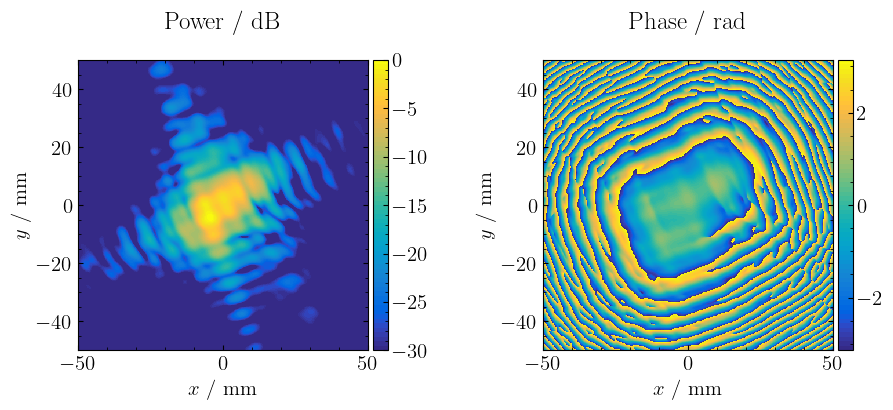

In [9]:
runPODict1 = {
        "t_name"    : "plane_up",
        "s_current" : "U1_source",
        "epsilon"   : 10,
        "exp"       : "fwd",
        "mode"      : "JMEH",
        "name_JM"   : "JM_up",
        "name_EH"   : "EH_up"
        }

runPODict2 = {
        "t_name"    : "plane_up",
        "s_current" : "U2_source",
        "epsilon"   : 10,
        "exp"       : "fwd",
        "mode"      : "JMEH",
        "name_JM"   : "JM_up2",
        "name_EH"   : "EH_up2"
        }

runPODict_bwd = {
        "t_name"    : "plane_down",
        "s_current" : "JM_up_combined",
        "epsilon"   : 10,
        "exp"       : "bwd",
        "mode"      : "JMEH",
        "name_JM"   : "JM_down",
        "name_EH"   : "EH_down"
        }

s.runPO(runPODict1)
s.runPO(runPODict2)

s.mergeBeams("EH_up", "EH_up2", merged_name="EH_up_combined")
s.mergeBeams("JM_up", "JM_up2", obj=Objects.CURRENT, merged_name="JM_up_combined")

s.runPO(runPODict_bwd)
s.plotBeam2D("EH_up_combined", FieldComponents.Ex, vmin=-30)

We propagate both rectangles separately to the upper plane. Here, we merge the two fields using the `s.mergeBeams()` method. This method accepts a sequence of fields or currents and merges this into a single object. It is necessary for the fields/currents to be defined on the same surface. If we want to merge currents, the "obj" keyword should be passed along with the value set to "currents".

We then propagate the combined current backwards to the plane below. This plane is at the same height as our rectangular sources. The direction of propagation is specified by the "exp" field in runPODict_bwd. This field defaults to "fwd', for forward propagation, and we set it to "bwd" to propagate backward.

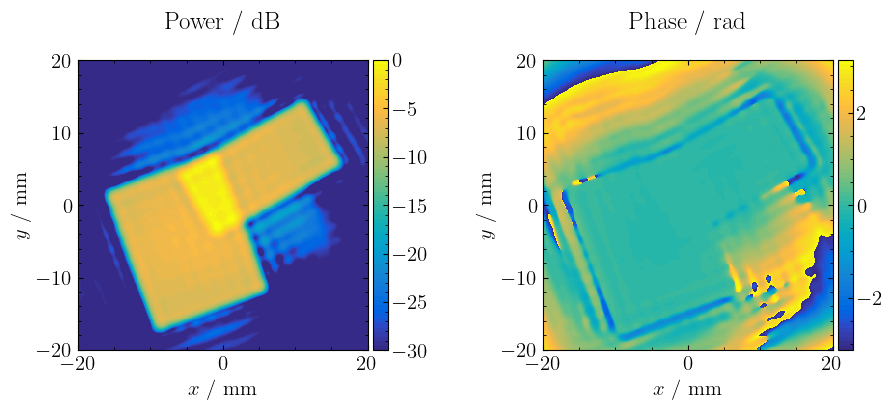

In [10]:
s.plotBeam2D("EH_down", FieldComponents.Ex, vmin=-30)

Upon inspection, the backwards propagated field resembles the rectangular sources quite well. If the phases of the source fields are the same, the overlap region should be brighter. If they are in anti-phase, the overlap should be dark.